In [1]:
!pip3 install nengo
!pip3 install nengo_dl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.3/535.3 kB 8.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nengo_dl: filename=nengo_dl-3.6.0-py3-none-any.whl size=204190 sha256=259f271279a1e4ac106bf701b742092ff487ec9f7051aae4799c851a3b8ea4b7
  Stored in directory: /root/.cache/pip/wheels/99/98/1a/c238f79c953dec26b4345dc4aa1a9b7b0b250bac1018985465
Successfully built nengo_dl


In [2]:
%matplotlib inline

from urllib.request import urlretrieve

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nengo_dl

11490434/11490434 [==============================] - 0s 0us/step


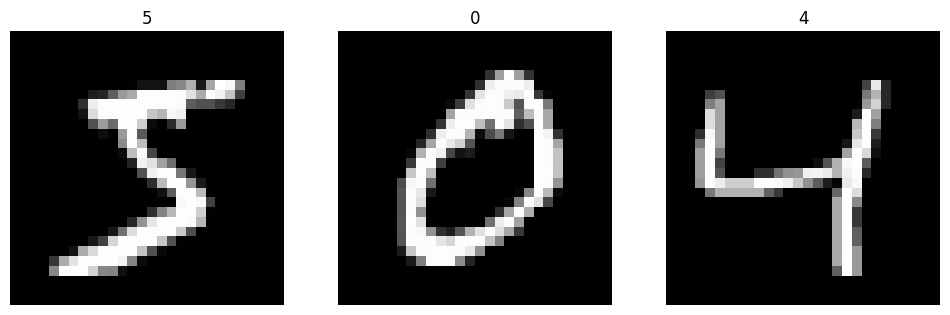

In [3]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.reshape(train_images[i], (28, 28)), cmap="gray")
    plt.axis("off")
    plt.title(str(train_labels[i]))


In [4]:
with nengo.Network(seed=0) as net:
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    neuron_type = nengo.LIF(amplitude=0.01)

    # this is an optimization to improve the training speed,
    # since we won't require stateful behaviour in this example
    nengo_dl.configure_settings(stateful=False)

    # the input node that will be used to feed in input images
    inp = nengo.Node(np.zeros(28 * 28))

    # add the first convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=32, kernel_size=3))(
        inp, shape_in=(28, 28, 1)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # add the second convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=64, strides=2, kernel_size=3))(
        x, shape_in=(26, 26, 32)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # add the third convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=128, strides=2, kernel_size=3))(
        x, shape_in=(12, 12, 64)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # linear readout
    out = nengo_dl.Layer(tf.keras.layers.Dense(units=10))(x)

    # we'll create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")


In [5]:
minibatch_size = 200
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

|###                   Building network (5%)                     | ETA: 0:00:02

/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


In [6]:
# add single timestep to training data
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]
#Rate encoding input data
n_steps = 30
test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))


In [7]:
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])


# note that we use `out_p_filt` when testing (to reduce the spike noise)
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy before training:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
)


Accuracy before training: 0.11100000143051147


In [8]:

# run training
sim.compile(
    optimizer=tf.optimizers.RMSprop(0.001),
    loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
)
sim.fit(train_images, {out_p: train_labels}, epochs=10)

# save the parameters to file
sim.save_params("./mnist_params")



Epoch 1/10
300/300 [==============================] - 253s 821ms/step - loss: 0.2735 - out_p_loss: 0.2735
Epoch 2/10
300/300 [==============================] - 244s 814ms/step - loss: 0.0704 - out_p_loss: 0.0704
Epoch 3/10
300/300 [==============================] - 248s 826ms/step - loss: 0.0480 - out_p_loss: 0.0480
Epoch 4/10
300/300 [==============================] - 244s 814ms/step - loss: 0.0383 - out_p_loss: 0.0383
Epoch 5/10
300/300 [==============================] - 245s 818ms/step - loss: 0.0302 - out_p_loss: 0.0302
Epoch 6/10
300/300 [==============================] - 246s 822ms/step - loss: 0.0244 - out_p_loss: 0.0244
Epoch 7/10
300/300 [==============================] - 245s 818ms/step - loss: 0.0200 - out_p_loss: 0.0200
Epoch 8/10
300/300 [==============================] - 245s 817ms/step - loss: 0.0163 - out_p_loss: 0.0163
Epoch 9/10
300/300 [==============================] - 243s 812ms/step - loss: 0.0133 - out_p_loss: 0.0133
Epoch 10/10
300/300 [=========================

In [9]:
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy after training:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
)


Accuracy after training: 0.9889000058174133
